## Reload the model

In [12]:
%load_ext autoreload
%autoreload 2

## Import library

Baseline acc: 0.8677685950413223 </br><br>
Baseline auc: 0.9231660389507519

## No loop

In [3]:
from pytorch_tabnet.tab_model import TabNetClassifier
import pytorch_tabnet.tab_model
import pytorch_tabnet
import pytorch_tabnet.tab_network
import torch
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score, accuracy_score

import pandas as pd
import numpy as np
np.random.seed(0)


import os
import wget
from pathlib import Path

from matplotlib import pyplot as plt
%matplotlib inline
import importlib

url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
dataset_name = 'census-income'
out = Path(os.getcwd()+'/data/'+dataset_name+'.csv')

out.parent.mkdir(parents=True, exist_ok=True)
if out.exists():
    print("File already exists.")
else:
    print("Downloading file...")
    wget.download(url, out.as_posix())
    
train = pd.read_csv(out)
target = ' <=50K'
if "Set" not in train.columns:
    train["Set"] = np.random.choice(["train", "valid", "test"], p =[.8, .1, .1], size=(train.shape[0],))

train_indices = train[train.Set=="train"].index
valid_indices = train[train.Set=="valid"].index
test_indices = train[train.Set=="test"].index

nunique = train.nunique()
types = train.dtypes

categorical_columns = []
categorical_dims =  {}
for col in train.columns:
    if types[col] == 'object' or nunique[col] < 200:
        print(col, train[col].nunique())
        l_enc = LabelEncoder()
        train[col] = train[col].fillna("VV_likely")
        train[col] = l_enc.fit_transform(train[col].values)
        categorical_columns.append(col)
        categorical_dims[col] = len(l_enc.classes_)
    else:
        train.fillna(train.loc[train_indices, col].mean(), inplace=True)
        
        
# check that pipeline accepts strings
train.loc[train[target]==0, target] = "wealthy"
train.loc[train[target]==1, target] = "not_wealthy"

unused_feat = ['Set']

features = [ col for col in train.columns if col not in unused_feat+[target]] 

cat_idxs = [ i for i, f in enumerate(features) if f in categorical_columns]

cat_dims = [ categorical_dims[f] for i, f in enumerate(features) if f in categorical_columns]

con_idxs = [i for i, f in enumerate(features) if f not in categorical_columns]

'''
X_train = train[features].values[train_indices]
y_train = train[target].values[train_indices]

X_valid = train[features].values[valid_indices]
y_valid = train[target].values[valid_indices]

X_test = train[features].values[test_indices]
y_test = train[target].values[test_indices]
'''
base_auc = 0.9231660389507519
base_acc = 0.8677685950413223
beat_auc = 0
beat_acc = 0
#### Customized train, valid, test
X_train = np.array(pd.read_csv('X_train.csv'))
y_train = np.array(pd.read_csv('y_train.csv')).ravel()

X_valid = np.array(pd.read_csv('X_valid.csv'))
y_valid = np.array(pd.read_csv('y_valid.csv')).ravel()

X_test = np.array(pd.read_csv('X_test.csv'))
y_test = np.array(pd.read_csv('y_test.csv')).ravel()

max_epochs = 7700 if not os.getenv("CI", False) else 2
auc = []
acc = []
clf = TabNetClassifier(cat_idxs=cat_idxs,
                       cat_dims=cat_dims,
                       cat_emb_dim=1,
                       con_idxs = con_idxs,
                       con_emb_dim = 44,
                       optimizer_fn=torch.optim.Adam,
                       optimizer_params=dict(lr=2e-2),
                       scheduler_params={"step_size":50, # how to use learning rate scheduler
                                         "gamma":0.9},
                       scheduler_fn=torch.optim.lr_scheduler.StepLR,
                       mask_type='entmax' # "sparsemax"
                      )

clf.fit(
                            X_train=X_train, y_train=y_train,
                            eval_set=[(X_train, y_train), (X_valid, y_valid)],
                            eval_name=['train', 'valid'],
                            eval_metric=['auc'],
                            max_epochs=max_epochs , patience=20,
                            batch_size=1024, virtual_batch_size=128,
                            num_workers=0,
                            weights=1,
                            drop_last=False
                        )

preds_class = clf.predict(X_test)
preds = clf.predict_proba(X_test)
test_acc = accuracy_score(y_test, preds_class)
test_auc = roc_auc_score(y_score=preds[:,1], y_true=y_test)
print("acc:", test_acc)
print("auc:", test_auc)

File already exists.
39 73
 State-gov 9
 Bachelors 16
 13 16
 Never-married 7
 Adm-clerical 15
 Not-in-family 6
 White 5
 Male 2
 2174 119
 0 92
 40 94
 United-States 42
 <=50K 2
Set 3
Device used : cpu
epoch 0  | loss: 0.69296 | train_auc: 0.56124 | valid_auc: 0.56487 |  0:00:03s
epoch 1  | loss: 0.55751 | train_auc: 0.7151  | valid_auc: 0.70731 |  0:00:07s
epoch 2  | loss: 0.5167  | train_auc: 0.79392 | valid_auc: 0.79364 |  0:00:11s
epoch 3  | loss: 0.4927  | train_auc: 0.82797 | valid_auc: 0.82798 |  0:00:15s
epoch 4  | loss: 0.45816 | train_auc: 0.85855 | valid_auc: 0.86151 |  0:00:19s
epoch 5  | loss: 0.43781 | train_auc: 0.87102 | valid_auc: 0.87654 |  0:00:23s
epoch 6  | loss: 0.41616 | train_auc: 0.86081 | valid_auc: 0.86958 |  0:00:27s
epoch 7  | loss: 0.4041  | train_auc: 0.89387 | valid_auc: 0.89289 |  0:00:31s
epoch 8  | loss: 0.39788 | train_auc: 0.90146 | valid_auc: 0.89973 |  0:00:36s
epoch 9  | loss: 0.38149 | train_auc: 0.8953  | valid_auc: 0.88988 |  0:00:40s
epoch 1

## Loop

In [1]:
from pytorch_tabnet.tab_model import TabNetClassifier
import pytorch_tabnet.tab_model
import pytorch_tabnet
import pytorch_tabnet.tab_network
import torch
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score, accuracy_score

import pandas as pd
import numpy as np
np.random.seed(0)


import os
import wget
from pathlib import Path

from matplotlib import pyplot as plt
%matplotlib inline
import importlib

url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
dataset_name = 'census-income'
out = Path(os.getcwd()+'/data/'+dataset_name+'.csv')

out.parent.mkdir(parents=True, exist_ok=True)
if out.exists():
    print("File already exists.")
else:
    print("Downloading file...")
    wget.download(url, out.as_posix())
    
train = pd.read_csv(out)
target = ' <=50K'
if "Set" not in train.columns:
    train["Set"] = np.random.choice(["train", "valid", "test"], p =[.8, .1, .1], size=(train.shape[0],))

train_indices = train[train.Set=="train"].index
valid_indices = train[train.Set=="valid"].index
test_indices = train[train.Set=="test"].index

nunique = train.nunique()
types = train.dtypes

categorical_columns = []
categorical_dims =  {}
for col in train.columns:
    if types[col] == 'object' or nunique[col] < 200:
        print(col, train[col].nunique())
        l_enc = LabelEncoder()
        train[col] = train[col].fillna("VV_likely")
        train[col] = l_enc.fit_transform(train[col].values)
        categorical_columns.append(col)
        categorical_dims[col] = len(l_enc.classes_)
    else:
        train.fillna(train.loc[train_indices, col].mean(), inplace=True)
        
        
# check that pipeline accepts strings
train.loc[train[target]==0, target] = "wealthy"
train.loc[train[target]==1, target] = "not_wealthy"

unused_feat = ['Set']

features = [ col for col in train.columns if col not in unused_feat+[target]] 

cat_idxs = [ i for i, f in enumerate(features) if f in categorical_columns]

cat_dims = [ categorical_dims[f] for i, f in enumerate(features) if f in categorical_columns]

con_idxs = [i for i, f in enumerate(features) if f not in categorical_columns]

'''
X_train = train[features].values[train_indices]
y_train = train[target].values[train_indices]

X_valid = train[features].values[valid_indices]
y_valid = train[target].values[valid_indices]

X_test = train[features].values[test_indices]
y_test = train[target].values[test_indices]
'''
base_auc = 0.9231660389507519
base_acc = 0.8677685950413223
beat_auc = 0
beat_acc = 0
#### Customized train, valid, test
X_train = np.array(pd.read_csv('X_train.csv'))
y_train = np.array(pd.read_csv('y_train.csv')).ravel()

X_valid = np.array(pd.read_csv('X_valid.csv'))
y_valid = np.array(pd.read_csv('y_valid.csv')).ravel()

X_test = np.array(pd.read_csv('X_test.csv'))
y_test = np.array(pd.read_csv('y_test.csv')).ravel()

max_epochs = 7700 if not os.getenv("CI", False) else 2
auc = []
acc = []
for con_dim in range(1, 17):
    clf = TabNetClassifier(
                           n_d = 8, 
                           n_a = 8,
                           cat_idxs=cat_idxs,
                           cat_dims=cat_dims,
                           cat_emb_dim=1,
                           con_idxs=con_idxs,
                           con_emb_dim=con_dim,
                           n_steps=3,
                           gamma=1.0,
                           lambda_sparse = 0.01,
                           momentum=0.98,
                           n_shared=2,
                           n_independent=2,
                           optimizer_fn=torch.optim.Adam,
                           optimizer_params=dict(lr=2e-2),
                           scheduler_params={"step_size":2500, # how to use learning rate scheduler
                                             "gamma":0.4},
                           scheduler_fn=torch.optim.lr_scheduler.StepLR,
                           mask_type='entmax' # "sparsemax"
                          )

    clf.fit(
                            X_train=X_train, y_train=y_train,
                            eval_set=[(X_train, y_train), (X_valid, y_valid)],
                            eval_name=['train', 'valid'],
                            eval_metric=['accuracy'],
                            max_epochs=max_epochs , patience=20,
                            batch_size=2048, virtual_batch_size=128,
                            num_workers=0,
                            weights=1,
                            drop_last=False
                        )

    preds_class = clf.predict(X_test)
    preds = clf.predict_proba(X_test)
    test_acc = accuracy_score(y_test, preds_class)
    test_auc = roc_auc_score(y_score=preds[:,1], y_true=y_test)
    print("acc:", test_acc, con_dim)
    print("auc:", test_auc, con_dim)
    if test_auc>base_auc:
        print("BEAT AUC")
        beat_auc = 1
    if test_acc>base_acc:
        print("BEAT ACC")
        beat_acc = 1
    auc.append(test_auc)
    acc.append(test_acc)

Running Yen model
File already exists.
39 73
 State-gov 9
 Bachelors 16
 13 16
 Never-married 7
 Adm-clerical 15
 Not-in-family 6
 White 5
 Male 2
 2174 119
 0 92
 40 94
 United-States 42
 <=50K 2
Set 3
Device used : cpu
epoch 0  | loss: 0.78362 | train_accuracy: 0.5344  | valid_accuracy: 0.53958 |  0:00:05s
epoch 1  | loss: 0.62432 | train_accuracy: 0.64429 | valid_accuracy: 0.64483 |  0:00:10s
epoch 2  | loss: 0.57601 | train_accuracy: 0.65193 | valid_accuracy: 0.6588  |  0:00:15s
epoch 3  | loss: 0.4943  | train_accuracy: 0.68506 | valid_accuracy: 0.67743 |  0:00:20s
epoch 4  | loss: 0.45714 | train_accuracy: 0.7439  | valid_accuracy: 0.75194 |  0:00:25s
epoch 5  | loss: 0.44225 | train_accuracy: 0.7872  | valid_accuracy: 0.78764 |  0:00:30s
epoch 6  | loss: 0.42705 | train_accuracy: 0.79396 | valid_accuracy: 0.80161 |  0:00:35s
epoch 7  | loss: 0.42089 | train_accuracy: 0.7113  | valid_accuracy: 0.70941 |  0:00:41s
epoch 8  | loss: 0.41125 | train_accuracy: 0.69446 | valid_accuracy

epoch 61 | loss: 0.31746 | train_accuracy: 0.80761 | valid_accuracy: 0.79727 |  0:04:16s
epoch 62 | loss: 0.32296 | train_accuracy: 0.84405 | valid_accuracy: 0.82707 |  0:04:21s
epoch 63 | loss: 0.31955 | train_accuracy: 0.82414 | valid_accuracy: 0.81    |  0:04:26s
epoch 64 | loss: 0.31297 | train_accuracy: 0.847   | valid_accuracy: 0.82707 |  0:04:31s
epoch 65 | loss: 0.31305 | train_accuracy: 0.84428 | valid_accuracy: 0.82831 |  0:04:36s
epoch 66 | loss: 0.31074 | train_accuracy: 0.83638 | valid_accuracy: 0.81993 |  0:04:40s
epoch 67 | loss: 0.30939 | train_accuracy: 0.85801 | valid_accuracy: 0.84042 |  0:04:45s
epoch 68 | loss: 0.31401 | train_accuracy: 0.83327 | valid_accuracy: 0.81776 |  0:04:50s
epoch 69 | loss: 0.3076  | train_accuracy: 0.87109 | valid_accuracy: 0.85688 |  0:04:55s
epoch 70 | loss: 0.31297 | train_accuracy: 0.82675 | valid_accuracy: 0.81093 |  0:05:00s
epoch 71 | loss: 0.31385 | train_accuracy: 0.8345  | valid_accuracy: 0.81807 |  0:05:05s
epoch 72 | loss: 0.31

epoch 34 | loss: 0.32468 | train_accuracy: 0.82541 | valid_accuracy: 0.81993 |  0:02:44s
epoch 35 | loss: 0.32397 | train_accuracy: 0.82341 | valid_accuracy: 0.81403 |  0:02:49s
epoch 36 | loss: 0.3277  | train_accuracy: 0.82874 | valid_accuracy: 0.82273 |  0:02:54s
epoch 37 | loss: 0.32137 | train_accuracy: 0.76987 | valid_accuracy: 0.76125 |  0:02:58s
epoch 38 | loss: 0.32754 | train_accuracy: 0.80243 | valid_accuracy: 0.79323 |  0:03:03s
epoch 39 | loss: 0.32179 | train_accuracy: 0.81263 | valid_accuracy: 0.80596 |  0:03:15s
epoch 40 | loss: 0.32141 | train_accuracy: 0.84263 | valid_accuracy: 0.83732 |  0:03:25s
epoch 41 | loss: 0.32567 | train_accuracy: 0.83557 | valid_accuracy: 0.82397 |  0:03:32s
epoch 42 | loss: 0.32007 | train_accuracy: 0.83484 | valid_accuracy: 0.82459 |  0:03:38s
epoch 43 | loss: 0.32309 | train_accuracy: 0.83818 | valid_accuracy: 0.83297 |  0:03:44s
epoch 44 | loss: 0.31815 | train_accuracy: 0.82966 | valid_accuracy: 0.81931 |  0:03:49s
epoch 45 | loss: 0.31

epoch 3  | loss: 0.51327 | train_accuracy: 0.67943 | valid_accuracy: 0.67929 |  0:00:18s
epoch 4  | loss: 0.48822 | train_accuracy: 0.68441 | valid_accuracy: 0.69482 |  0:00:23s
epoch 5  | loss: 0.47753 | train_accuracy: 0.70731 | valid_accuracy: 0.71624 |  0:00:28s
epoch 6  | loss: 0.46256 | train_accuracy: 0.71759 | valid_accuracy: 0.72679 |  0:00:33s
epoch 7  | loss: 0.45473 | train_accuracy: 0.71586 | valid_accuracy: 0.72276 |  0:00:37s
epoch 8  | loss: 0.44998 | train_accuracy: 0.72545 | valid_accuracy: 0.72679 |  0:00:42s
epoch 9  | loss: 0.43045 | train_accuracy: 0.73972 | valid_accuracy: 0.74946 |  0:00:47s
epoch 10 | loss: 0.42709 | train_accuracy: 0.72426 | valid_accuracy: 0.73083 |  0:00:52s
epoch 11 | loss: 0.41294 | train_accuracy: 0.79752 | valid_accuracy: 0.79696 |  0:00:56s
epoch 12 | loss: 0.4062  | train_accuracy: 0.73961 | valid_accuracy: 0.75287 |  0:01:01s
epoch 13 | loss: 0.39831 | train_accuracy: 0.74225 | valid_accuracy: 0.7507  |  0:01:06s
epoch 14 | loss: 0.39

epoch 61 | loss: 0.32008 | train_accuracy: 0.80535 | valid_accuracy: 0.79727 |  0:05:01s
epoch 62 | loss: 0.3237  | train_accuracy: 0.81543 | valid_accuracy: 0.7982  |  0:05:05s
epoch 63 | loss: 0.32193 | train_accuracy: 0.85716 | valid_accuracy: 0.8457  |  0:05:10s
epoch 64 | loss: 0.31494 | train_accuracy: 0.87216 | valid_accuracy: 0.8665  |  0:05:15s
epoch 65 | loss: 0.31421 | train_accuracy: 0.86533 | valid_accuracy: 0.85005 |  0:05:20s
epoch 66 | loss: 0.31339 | train_accuracy: 0.85517 | valid_accuracy: 0.84197 |  0:05:25s
epoch 67 | loss: 0.31196 | train_accuracy: 0.84531 | valid_accuracy: 0.83452 |  0:05:30s
epoch 68 | loss: 0.31255 | train_accuracy: 0.83258 | valid_accuracy: 0.828   |  0:05:34s
epoch 69 | loss: 0.31028 | train_accuracy: 0.84669 | valid_accuracy: 0.83142 |  0:05:39s
epoch 70 | loss: 0.31403 | train_accuracy: 0.85379 | valid_accuracy: 0.84104 |  0:05:44s
epoch 71 | loss: 0.31249 | train_accuracy: 0.82882 | valid_accuracy: 0.81993 |  0:05:49s
epoch 72 | loss: 0.31

epoch 24 | loss: 0.34284 | train_accuracy: 0.75299 | valid_accuracy: 0.7538  |  0:01:59s
epoch 25 | loss: 0.3366  | train_accuracy: 0.81873 | valid_accuracy: 0.81341 |  0:02:04s
epoch 26 | loss: 0.32942 | train_accuracy: 0.7729  | valid_accuracy: 0.76529 |  0:02:09s
epoch 27 | loss: 0.33525 | train_accuracy: 0.76131 | valid_accuracy: 0.76063 |  0:02:14s
epoch 28 | loss: 0.334   | train_accuracy: 0.7253  | valid_accuracy: 0.72245 |  0:02:18s
epoch 29 | loss: 0.33382 | train_accuracy: 0.77911 | valid_accuracy: 0.77398 |  0:02:23s
epoch 30 | loss: 0.33002 | train_accuracy: 0.77159 | valid_accuracy: 0.76808 |  0:02:28s
epoch 31 | loss: 0.32853 | train_accuracy: 0.79465 | valid_accuracy: 0.78733 |  0:02:33s
epoch 32 | loss: 0.32809 | train_accuracy: 0.75802 | valid_accuracy: 0.74946 |  0:02:37s
epoch 33 | loss: 0.33163 | train_accuracy: 0.76814 | valid_accuracy: 0.76591 |  0:02:42s
epoch 34 | loss: 0.32584 | train_accuracy: 0.80535 | valid_accuracy: 0.80068 |  0:02:47s
epoch 35 | loss: 0.32

epoch 14 | loss: 0.38585 | train_accuracy: 0.62734 | valid_accuracy: 0.62651 |  0:01:15s
epoch 15 | loss: 0.38779 | train_accuracy: 0.70382 | valid_accuracy: 0.7091  |  0:01:21s
epoch 16 | loss: 0.3828  | train_accuracy: 0.61752 | valid_accuracy: 0.61813 |  0:01:26s
epoch 17 | loss: 0.37132 | train_accuracy: 0.66301 | valid_accuracy: 0.66718 |  0:01:31s
epoch 18 | loss: 0.37649 | train_accuracy: 0.67275 | valid_accuracy: 0.67184 |  0:01:36s
epoch 19 | loss: 0.37527 | train_accuracy: 0.555   | valid_accuracy: 0.55262 |  0:01:41s
epoch 20 | loss: 0.36579 | train_accuracy: 0.63098 | valid_accuracy: 0.63148 |  0:01:47s
epoch 21 | loss: 0.361   | train_accuracy: 0.6255  | valid_accuracy: 0.62589 |  0:01:52s
epoch 22 | loss: 0.35702 | train_accuracy: 0.62792 | valid_accuracy: 0.62713 |  0:01:57s
epoch 23 | loss: 0.35577 | train_accuracy: 0.60858 | valid_accuracy: 0.60385 |  0:02:02s
epoch 24 | loss: 0.35963 | train_accuracy: 0.68138 | valid_accuracy: 0.67774 |  0:02:07s
epoch 25 | loss: 0.35

epoch 40 | loss: 0.33528 | train_accuracy: 0.80795 | valid_accuracy: 0.79944 |  0:03:21s
epoch 41 | loss: 0.34168 | train_accuracy: 0.81854 | valid_accuracy: 0.81496 |  0:03:26s
epoch 42 | loss: 0.3342  | train_accuracy: 0.79484 | valid_accuracy: 0.79292 |  0:03:31s
epoch 43 | loss: 0.33876 | train_accuracy: 0.81858 | valid_accuracy: 0.81931 |  0:03:36s
epoch 44 | loss: 0.33294 | train_accuracy: 0.82775 | valid_accuracy: 0.82242 |  0:03:41s
epoch 45 | loss: 0.32906 | train_accuracy: 0.83641 | valid_accuracy: 0.83142 |  0:03:46s
epoch 46 | loss: 0.33936 | train_accuracy: 0.83446 | valid_accuracy: 0.82614 |  0:03:51s
epoch 47 | loss: 0.33103 | train_accuracy: 0.81678 | valid_accuracy: 0.81093 |  0:03:56s
epoch 48 | loss: 0.33015 | train_accuracy: 0.83595 | valid_accuracy: 0.82583 |  0:04:01s
epoch 49 | loss: 0.33323 | train_accuracy: 0.80397 | valid_accuracy: 0.80037 |  0:04:06s
epoch 50 | loss: 0.33404 | train_accuracy: 0.8152  | valid_accuracy: 0.81403 |  0:04:11s
epoch 51 | loss: 0.32

epoch 20 | loss: 0.35866 | train_accuracy: 0.74244 | valid_accuracy: 0.74076 |  0:01:43s
epoch 21 | loss: 0.35736 | train_accuracy: 0.75372 | valid_accuracy: 0.7479  |  0:01:48s
epoch 22 | loss: 0.35212 | train_accuracy: 0.77067 | valid_accuracy: 0.76001 |  0:01:53s
epoch 23 | loss: 0.35509 | train_accuracy: 0.77106 | valid_accuracy: 0.7656  |  0:01:57s
epoch 24 | loss: 0.35408 | train_accuracy: 0.76319 | valid_accuracy: 0.75939 |  0:02:02s
epoch 25 | loss: 0.35138 | train_accuracy: 0.75084 | valid_accuracy: 0.73455 |  0:02:07s
epoch 26 | loss: 0.33959 | train_accuracy: 0.79898 | valid_accuracy: 0.79882 |  0:02:12s
epoch 27 | loss: 0.34441 | train_accuracy: 0.7793  | valid_accuracy: 0.76871 |  0:02:17s
epoch 28 | loss: 0.34751 | train_accuracy: 0.79817 | valid_accuracy: 0.78889 |  0:02:22s
epoch 29 | loss: 0.34249 | train_accuracy: 0.78463 | valid_accuracy: 0.77802 |  0:02:27s
epoch 30 | loss: 0.34076 | train_accuracy: 0.80094 | valid_accuracy: 0.79199 |  0:02:32s
epoch 31 | loss: 0.33

In [20]:
print("Beat_auc?", bool(beat_auc))
print("Beat_acc?", bool(beat_acc))

Beat_auc? True
Beat_acc? True


In [21]:
(auc)

[0.9235986263497595,
 0.9205567167306307,
 0.9270342850426455,
 0.9203615030431872,
 0.9180554774814367,
 0.9218848852480799,
 0.921284168783185,
 0.925248744142312,
 0.9215813330744111,
 0.9216339692257376,
 0.9279968111690847,
 0.9223826290480011,
 0.9144102962444363,
 0.9234619256654897,
 0.9239430609710604,
 0.9155851555832648]

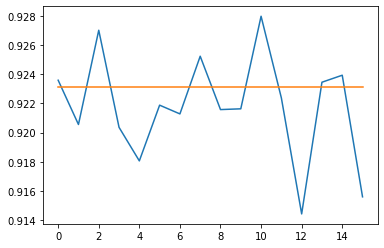

In [22]:
base_auc_plot = [base_auc]*16
plt.plot(auc)
plt.plot(base_auc_plot)

AUC SCORE SUMMARY
[0.8968060587787392, 0.919518558076072, 0.8596321601774299, 0.925464654568869, 0.9243746263088771, 0.9058788959695017, 0.9178906701144198, 0.9154259695527971, 0.9201550466826449, 0.9026778003199052, 0.8977800830935748, 0.9000112426730988, 0.9278797851627376, 0.8728147054164133, 0.9246393401572952, 0.8364436358804801]
Different in percentage
[-2.63599802 -0.36474809 -6.35338788  0.22986156  0.12085874 -1.7287143
 -0.52753688 -0.77400694 -0.30109923 -2.04882386 -2.53859559 -2.31547963
  0.47137462 -5.03513335  0.14733012 -8.67224031]


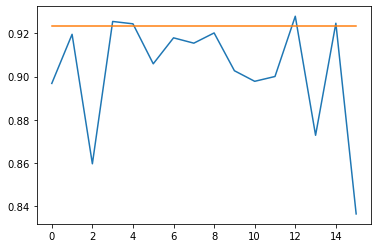

In [2]:
print("AUC SCORE SUMMARY")
print(auc)
print("Different in percentage")
print((np.array(auc) - base_auc)*100)
base_auc_plot = [base_auc]*16
plt.plot(auc)
plt.plot(base_auc_plot)

ACCURACY SCORE SUMMARY
[0.8010407101316193, 0.8552188552188552, 0.8056320783593511, 0.8741965105601469, 0.8567493112947658, 0.8071625344352618, 0.8631772268135904, 0.8273645546372819, 0.8582797673706765, 0.8218549127640037, 0.8050198959289868, 0.8004285277012549, 0.8484848484848485, 0.8197122742577289, 0.8408325681052954, 0.7517600244872972]
DIFFERENT IN PERCENTAGE
[ -6.67278849  -1.25497398  -6.21365167   0.64279155  -1.10192837
  -6.06060606  -0.45913682  -4.04040404  -0.94888277  -4.59136823
  -6.27486991  -6.73400673  -1.92837466  -4.80563208  -2.69360269
 -11.60085706]


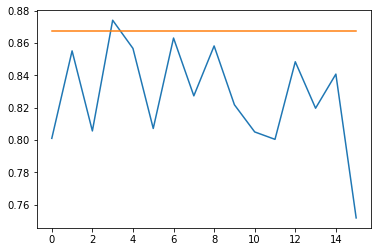

In [3]:
print("ACCURACY SCORE SUMMARY")
print(acc)
print("DIFFERENT IN PERCENTAGE")
print((np.array(acc) - base_acc)*100)
base_acc_plot = [base_acc]*len(acc)
plt.plot(acc)
plt.plot(base_acc_plot)

In [10]:
(np.array(auc) - base_auc)*100

array([-0.07200421,  0.14835218,  0.11510964,  0.2606256 ,  0.00388383,
       -0.04711702, -0.09203661, -0.01883148,  0.51120946, -0.1403801 ,
        0.15969706,  0.61712055,  0.07200421,  0.38868987,  0.07857095,
       -0.15177609])

In [11]:
(np.array(acc) - base_acc)*100

array([-1.74471993, -6.45852464, -5.75451485, -5.35659627, -7.37679829,
       -4.46893174, -4.4077135 , -6.33608815, -7.04009795, -5.84634221,
       -3.30578512, -4.53014998, -5.87695133, -2.81603918, -1.71411081,
       -5.63207836])

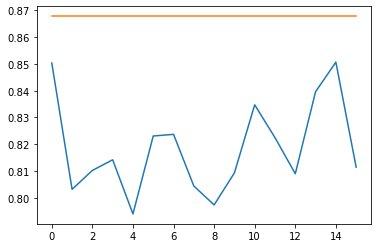

In [18]:
base_acc_plot = [base_acc]*16
plt.plot(acc)
plt.plot(base_acc_plot)

Beat acc with emb = 5 <br>
beat auc with emb = 10

In [ ]:
preds = clf.predict_proba(X_test)
test_auc = roc_auc_score(y_score=preds[:,1], y_true=y_test)
test_auc

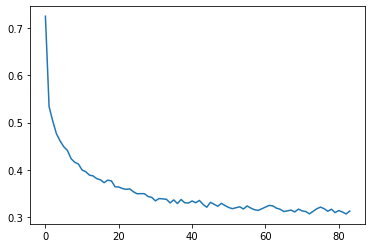

In [3]:
# plot losses
plt.plot(clf.history['loss'])

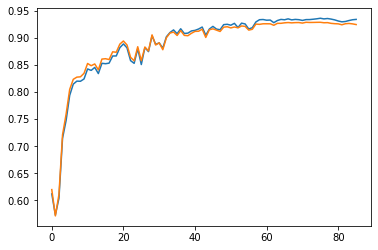

In [3]:
# plot auc
plt.plot(clf.history['train_auc'])
plt.plot(clf.history['valid_auc'])

In [4]:
preds = clf.predict_proba(X_test)
test_auc = roc_auc_score(y_score=preds[:,1], y_true=y_test)


preds_valid = clf.predict_proba(X_valid)
valid_auc = roc_auc_score(y_score=preds_valid[:,1], y_true=y_valid)

print(f"BEST VALID SCORE FOR {dataset_name} : {clf.best_cost}")
print(f"FINAL TEST SCORE FOR {dataset_name} : {test_auc}")

BEST VALID SCORE FOR census-income : 0.928799966758082
FINAL TEST SCORE FOR census-income : 0.9251232861311407


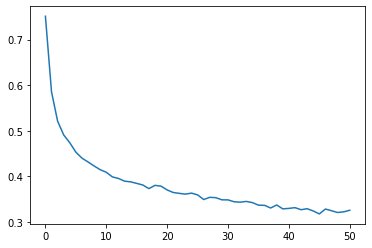

In [9]:
# plot losses
plt.plot(clf.history['loss'])

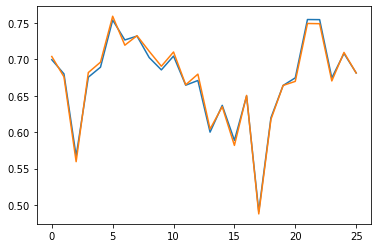

In [5]:
# plot auc
plt.plot(clf.history['train_accuracy'])
plt.plot(clf.history['valid_accuracy'])

In [11]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
preds = clf.predict_proba(X_test)
preds_class = clf.predict(X_test)
test_auc = roc_auc_score(y_score=preds[:,1], y_true=y_test)
test_acc = accuracy_score(preds_class, y_test)

preds_valid = clf.predict_proba(X_valid)
valid_auc = roc_auc_score(y_score=preds_valid[:,1], y_true=y_valid)

print(f"BEST VALID SCORE FOR {dataset_name} : {clf.best_cost}")
print(f"FINAL TEST AUC SCORE FOR {dataset_name} : {test_auc}")
print(f"FINAL TEST ACC SCORE FOR {dataset_name} : {test_acc}")


BEST VALID SCORE FOR census-income : 0.928799966758082
FINAL TEST AUC SCORE FOR census-income : 0.9251232861311407
FINAL TEST ACC SCORE FOR census-income : 0.7894092439546985


In [14]:
print("Confusion matrix")
print(confusion_matrix(preds_class, y_test))
print("Classification report")
print(classification_report(preds_class, y_test))
print("Test set accuracy:\t", accuracy_score(preds_class, y_test))
print(f"FINAL TEST AUC SCORE FOR {dataset_name} : {roc_auc_score(preds_class, y_test)}")


Confusion matrix
[[ 715  613]
 [  75 1864]]
Classification report
              precision    recall  f1-score   support

 not_wealthy       0.91      0.54      0.68      1328
     wealthy       0.75      0.96      0.84      1939

    accuracy                           0.79      3267
   macro avg       0.83      0.75      0.76      3267
weighted avg       0.81      0.79      0.78      3267

Test set accuracy:	 0.7894092439546985


ValueError: could not convert string to float: 'not_wealthy'

In [ ]:
preds_test

In [5]:
clf.history['train_auc'][-1]

0.5

In [50]:
len(X_train)/1024


25.4609375

In [ ]:
#importlib.reload(pytorch_tabnet.tab_model)

# Download census-income dataset

# Load data and split

# Simple preprocessing

Label encode categorical features and fill empty cells.

# Define categorical features for categorical embeddings

In [ ]:
print("cat_idxs")
print(cat_idxs)
print("cat_dims")
print(cat_dims)
print("con_idxs")
print(con_idxs)

# Network parameters

# Training

In [ ]:
input_dim = 5
cat_idxs = [0,1,4]
con_idxs = [2,3]
cat_dims = [10, 11, 14]
cat_emb_dim = [20, 21, 24]
con_emb_dim = [22, 23]

embedding_dim_info = []
for idx in range(input_dim):
    if idx in cat_idxs:
        embedding_dim_info.append((cat_dims[cat_idxs.index(idx)], cat_emb_dim[cat_idxs.index(idx)]))
    if idx in con_idxs:
        embedding_dim_info.append((1, con_emb_dim[con_idxs.index(idx)]))
embedding_dim_info

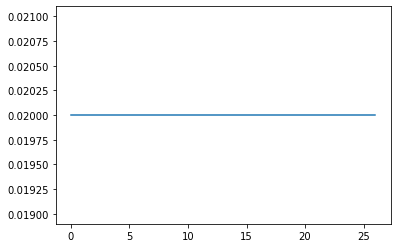

In [4]:
# plot learning rates
plt.plot(clf.history['lr'])

## Predictions

In [5]:
# check that best weights are used
assert np.isclose(valid_auc, np.max(clf.history['valid_auc']), atol=1e-6)

In [6]:
clf.predict(X_test)

array(['not_wealthy', 'wealthy', 'wealthy', ..., 'not_wealthy', 'wealthy',
       'wealthy'], dtype='<U11')

# Save and load Model

In [8]:
# save tabnet model
saving_path_name = "./tabnet_model_test_1"
saved_filepath = clf.save_model(saving_path_name)

Successfully saved model at ./tabnet_model_test_1.zip


In [ ]:
# define new model with basic parameters and load state dict weights
loaded_clf = TabNetClassifier()
loaded_clf.load_model(saved_filepath)

In [ ]:
loaded_preds = loaded_clf.predict_proba(X_test)
loaded_test_auc = roc_auc_score(y_score=loaded_preds[:,1], y_true=y_test)

print(f"FINAL TEST SCORE FOR {dataset_name} : {loaded_test_auc}")

In [ ]:
assert(test_auc == loaded_test_auc)

In [ ]:
loaded_clf.predict(X_test)

# Global explainability : feat importance summing to 1

In [ ]:
clf.feature_importances_

# Local explainability and masks

In [ ]:
explain_matrix, masks = clf.explain(X_test)

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(20,20))

for i in range(3):
    axs[i].imshow(masks[i][:50])
    axs[i].set_title(f"mask {i}")


# XGB

In [15]:
from xgboost import XGBClassifier

clf_xgb = XGBClassifier(max_depth=8,
    learning_rate=0.1,
    n_estimators=1000,
    verbosity=0,
    silent=None,
    objective='binary:logistic',
    booster='gbtree',
    n_jobs=-1,
    nthread=None,
    gamma=0,
    min_child_weight=1,
    max_delta_step=0,
    subsample=0.7,
    colsample_bytree=1,
    colsample_bylevel=1,
    colsample_bynode=1,
    reg_alpha=0,
    reg_lambda=1,
    scale_pos_weight=1,
    base_score=0.5,
    random_state=0,
    seed=None,)

clf_xgb.fit(X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        early_stopping_rounds=40,
        verbose=10)

[0]	validation_0-logloss:0.63523


C:\Users\root\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10]	validation_0-logloss:0.37927
[20]	validation_0-logloss:0.31122
[30]	validation_0-logloss:0.28684
[40]	validation_0-logloss:0.27723
[50]	validation_0-logloss:0.27253
[60]	validation_0-logloss:0.26951
[70]	validation_0-logloss:0.26908
[80]	validation_0-logloss:0.26752
[90]	validation_0-logloss:0.26729
[100]	validation_0-logloss:0.26748
[110]	validation_0-logloss:0.26783
[120]	validation_0-logloss:0.26779
[130]	validation_0-logloss:0.26815
[140]	validation_0-logloss:0.26878
[142]	validation_0-logloss:0.26913


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=8,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=1000, n_jobs=-1, nthread=8, num_parallel_tree=1,
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=0, silent=None, subsample=0.7, tree_method='exact',
              validate_parameters=1, verbosity=0)

In [16]:
preds = np.array(clf_xgb.predict_proba(X_valid))
valid_auc = roc_auc_score(y_score=preds[:,1], y_true=y_valid)
print(valid_auc)

preds = np.array(clf_xgb.predict_proba(X_test))
test_auc = roc_auc_score(y_score=preds[:,1], y_true=y_test)
print(test_auc)

0.9336413537984218
0.9244487257452103


C:\Users\root\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\root\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


In [17]:
preds = np.array(clf_xgb.predict(X_test))
test_acc = accuracy_score(y_test, preds)
print(test_acc)

0.8760330578512396


C:\Users\root\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
